# 青春有你2 评论分析改进
**1. 使用了异步协程进行爬取，53秒内可以爬取完 33万条数据。**

**2. 数据清洗中使用了人名去重，最终对人名频次统计进行输出，可以用于最终名次预测。**

**3. TODO PaddlePaddle 情感分析数据集时间过久，导致预测结果不准确，可使用自建数据集重新训练。**

**第一步：爱奇艺《青春有你2》评论数据爬取**(参考链接：[https://www.iqiyi.com/v_19ryfkiv8w.html#curid=15068699100_9f9bab7e0d1e30c494622af777f4ba39](http://))
* 爬取任意一期正片视频下评论
* 评论条数不少于1000条

**第二步：词频统计并可视化展示**
* 数据预处理：清理清洗评论中特殊字符（如：@#￥%、emoji表情符）,清洗后结果存储为txt文档
* 中文分词：添加新增词（如：青你、奥利给、冲鸭），去除停用词（如：哦、因此、不然、也好、但是）
* 统计top10高频词
* 可视化展示高频词

**第三步：绘制词云**
* 根据词频生成词云
* 可选项-添加背景图片，根据背景图片轮廓生成词云 

**第四步：结合PaddleHub，对评论进行内容审核**


# 需要的配置和准备
* 中文分词需要jieba
* 词云绘制需要wordcloud
* 可视化展示中需要的中文字体
* 网上公开资源中找一个中文停用词表
* 根据分词结果自己制作新增词表
* 准备一张词云背景图（附加项，不做要求，可用hub抠图实现）
* paddlehub配置



In [77]:
!pip install jieba
!pip install wordcloud
!pip install nest_asyncio
!pip install aiohttp

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/


In [78]:
# !pip install beautifulsoup4 -t ./external-libraries
# !pip install lxml -t ./external-libraries
import sys
sys.path.append('./external-libraries')

In [79]:
# Linux系统默认字体文件路径
# !ls /usr/share/fonts/
# 查看系统可用的ttf格式中文字体
!fc-list :lang=zh | grep ".ttf"

/home/aistudio/.fonts/SimHei.ttf: SimHei,黑体:style=Regular,Normal,obyčejné,Standard,Κανονικά,Normaali,Normál,Normale,Standaard,Normalny,Обычный,Normálne,Navadno,Arrunta


In [80]:
# !wget https://mydueros.cdn.bcebos.com/font/simhei.ttf # 下载中文字体
#创建字体目录fonts
!mkdir -p .fonts
# 复制字体文件到该路径
!cp *.ttf .fonts/
!cp *.ttf /opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/
!ls .fonts/

SimHei.ttf


In [81]:
!pip install --upgrade paddlehub

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
Requirement already up-to-date: paddlehub in /opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages (1.8.3)


In [82]:
!hub install emotion_detection_textcnn==1.1.0

Module emotion_detection_textcnn-1.1.0 already installed in /home/aistudio/.paddlehub/modules/emotion_detection_textcnn


In [83]:
from __future__ import print_function
import requests
import json
import re #正则匹配
import time #时间处理模块
import jieba #中文分词
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator  #绘制词云模块
import paddlehub as hub
import pandas as pd
from bs4 import BeautifulSoup
from multiprocessing import Process,Manager
from threading import Thread
import aiohttp

In [84]:
#根据content_id，获取评论
async def getMovieinfo(content_id):
    page = 1
    headers = { 
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36'
    }
    upremaining = 0
    while upremaining!=1 :
        url = 'https://sns-comment.iqiyi.com/v3/comment/get_comments.action?agent_type=118&agent_version=9.11.5&authcookie=null&business_type=17&content_id='+content_id+'&hot_size=0&last_id=&page='+str(page)+'&page_size=40&types=time'
        # response = requests.get(url,headers=headers)
        async with aiohttp.ClientSession(headers=headers, connector=aiohttp.TCPConnector(ssl=False)) as session:
            async with session.get(url) as response:
                # print(f'start crawling content {content_id} page {page}')
                resjson = json.loads(await response.text())
                upremaining = resjson['data']['upremaining']
                coms = resjson['data']['comments']
                for val in coms:
                    if 'content' in val.keys():
                        comments.append(val['content'])
                # print(f'finish crawling page {page}')
                page+=1
#获取视频列表    
def getMovies():
    content_ids=[]
    url = 'https://www.iqiyi.com/v_19ryi480ks.html'
    headers = { 
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36'
    }
    
    response = requests.get(url,headers=headers)
    soup = BeautifulSoup(response.text,'lxml')
    li = soup.find_all('li',{'class':'play-list-item'})
    for x in li:
        content_ids.append(x['data-td'])
    return content_ids[1:] #去除第一个预告片
  
#协程异步获取评论
async def saveMovieInfoToFile():
    content_ids= getMovies()
    tasks = [getMovieinfo(content_id) for content_id in content_ids]
    await asyncio.gather(*tasks)
    print("总共获取了",len(comments),'条评论')

In [85]:
#去除文本中特殊字符
def clear_special_char():
    global comments
    '''
    正则处理特殊字符
    参数 content:原文本
    return: 清除后的文本
    '''

    import re
    from string import digits, punctuation
    for i in range(len(comments)):
        s = comments[i]
        # print(i)
        # print(s)
        rule = re.compile(u'[^a-zA-Z.,;《》？！“”‘’@#￥%…&×（）——+【】{};；●，。&～、|\s:：' + digits + punctuation + '\u4e00-\u9fa5]+')
        s = re.sub(rule, '', s)
        s = re.sub('[、]+', '，', s)
        s = re.sub('\'', '', s)
        s = re.sub('[#]+', '，', s)
        s = re.sub('[?]+', '？', s)
        s = re.sub('[;]+', '，', s)
        s = re.sub('[,]+', '，', s)
        s = re.sub('[!]+', '！', s)
        s = re.sub('[！]+', '！', s)
        s = re.sub('[？]+', '？', s)
        s = re.sub('[.]+', '.', s)
        s = re.sub('[，]+', '，', s)
        s = re.sub('[。]+', '。', s)
        s = re.sub('/([?!.])\1+/', '$1', s)
        # 人名去重
        for name in names:
            s = re.sub('('+name+')+',name,s)
        # 去除表情
        s = re.sub(r"\[\S+\]", "", s)
        comments[i] = s
    return


In [86]:
def fenci(text):
    '''
    利用jieba进行分词
    参数 text:需要分词的句子或文本
    return：分词结果
    '''
    jieba.load_userdict('name.txt')
    seg = jieba.lcut(text,cut_all=False)
    return seg


In [87]:
def stopwordslist(file_path):
    '''
    创建停用词表
    参数 file_path:停用词文本路径
    return：停用词list
    '''
    stopwords = [line.strip() for line in open(file_path, encoding="UTF-8").readlines()]
    return stopwords

In [88]:
def movestopwords(sentence, stopwords, counts):
    '''
    去除停用词,统计词频
    参数 file_path:停用词文本路径 stopwords:停用词list counts: 词频统计结果
    return：None
    '''
    for word in sentence:
        if word not in stopwords:
            if len(word) > 1:
                counts[word] = counts.get(word, 0) + 1
    return None
    

In [89]:
def drawcounts(counts,num):
    '''
    绘制词频统计表
    参数 counts: 词频统计结果 num:绘制topN
    return：none
    '''
    sort_counts =  sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
    x = []
    y = []
    count = 0
    for s in sort_counts:
        if s[0] in names:#筛选选手名
            x.append(s[0])
            y.append(s[1])
            count+=1
        if count == num:
            break

    matplotlib.rcParams['font.sans-serif'] = ['SimHei']
    matplotlib.rcParams['axes.unicode_minus'] = False
    from matplotlib.font_manager import _rebuild
    _rebuild() #reload一下
    plt.figure(figsize=(10, 10))
    plt.barh(x, y)
    plt.title('青春有你2 选手词频统计')
    plt.show()
    return
    

In [90]:
def drawcloud(word_f):
    '''
    根据词频绘制词云图
    参数 word_f:统计出的词频结果
    return：none
    '''
    wc = WordCloud(random_state=42,width=800,height=400, relative_scaling=0.3, font_path='SimHei.ttf',background_color='white')

    # generate word cloud
    wc.fit_words(word_f)


    plt.figure(figsize=(10, 12))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()    
    wc.to_file('wordcloud.png')

In [91]:
def text_detection():
    '''
    使用hub对评论进行内容分析
    return：分析结果

    '''

    module = hub.Module(name="emotion_detection_textcnn")
    
    test_text = list(comments)
    input_dict = {"text": test_text}
    results = module.emotion_classify(data=input_dict)

    for result in results:
            if result['emotion_key']=='positive':
                positive.append(result['text'])
            elif result['emotion_key']=='neutral':
                neutral.append(result['text'])
            elif result['emotion_key']=='negative':
                negative.append(result['text'])
def draw_pie():
    labels = ["正向",'中性','负面']
    plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
    matplotlib.rcParams.update({'font.size': 16})
    plt.figure(figsize=(12, 12))
    plt.pie([len(positive),len(neutral),len(negative)], explode=(0.1,0.1,0.1),labels=labels, shadow=True,autopct='%.2f%%',startangle=90)
    plt.axis('equal')
    plt.legend(loc="upper right",fontsize=10,bbox_to_anchor=(1.1,1.05),borderaxespad=0.3)
    plt.title('''《青春有你2》评价分析''',fontsize = 20)
    plt.savefig('pie.jpg')

In [92]:
#评论是多分页的，得多次请求爱奇艺的评论接口才能获取多页评论,有些评论含有表情、特殊字符之类的
comments = []
counts ={}
names = [line.strip() for line in open('name.txt', encoding="UTF-8").readlines()]
if __name__ == "__main__":
    asyncio.run(saveMovieInfoToFile())

总共获取了 332830 条评论


In [93]:

with open('output.txt', 'w') as file:  # Use file to refer to the file object
    json.dump(comments, file)

In [94]:
with open('output.txt', 'r') as file:  # Use file to refer to the file object
        comments = json.load(file)
clear_special_char()

In [95]:
comments = tuple(comments)
stopwords = stopwordslist('cn_stopwords.txt')
i = 1
for comment in comments:
    sentence = fenci(comment)
    movestopwords(sentence, stopwords, counts)
    if i%10000 == 0:
        print(f"已处理了{i}条数据。")
    i+=1

已处理了10000条数据。
已处理了20000条数据。
已处理了30000条数据。
已处理了40000条数据。
已处理了50000条数据。
已处理了60000条数据。
已处理了70000条数据。
已处理了80000条数据。
已处理了90000条数据。
已处理了100000条数据。
已处理了110000条数据。
已处理了120000条数据。
已处理了130000条数据。
已处理了140000条数据。
已处理了150000条数据。
已处理了160000条数据。
已处理了170000条数据。
已处理了180000条数据。
已处理了190000条数据。
已处理了200000条数据。
已处理了210000条数据。
已处理了220000条数据。
已处理了230000条数据。
已处理了240000条数据。
已处理了250000条数据。
已处理了260000条数据。
已处理了270000条数据。
已处理了280000条数据。
已处理了290000条数据。
已处理了300000条数据。
已处理了310000条数据。
已处理了320000条数据。
已处理了330000条数据。


2020-12-12 13:17:24,272-INFO: font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2020-12-12 13:17:24,648-INFO: generated new fontManager


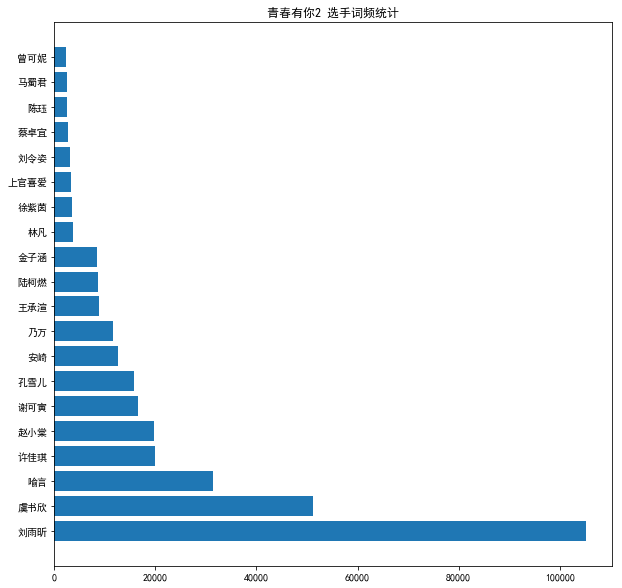

In [96]:
drawcounts(counts,20)

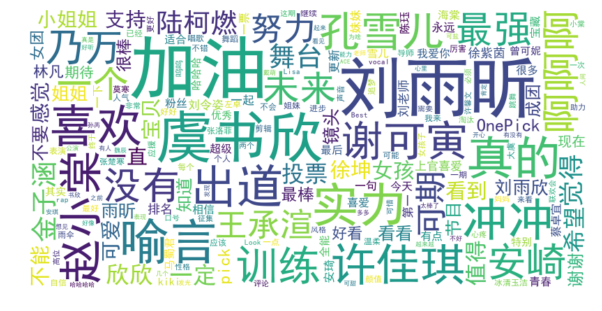

In [97]:
drawcloud(counts)

In [98]:
positive = []
neutral = []
negative = []
text_detection()

[2020-12-12 13:17:26,375] [    INFO] - Installing emotion_detection_textcnn module
[2020-12-12 13:17:26,446] [    INFO] - Module emotion_detection_textcnn already installed in /home/aistudio/.paddlehub/modules/emotion_detection_textcnn
[2020-12-12 13:17:26,852] [    INFO] - Installing lac module


[==================================================] 100.00%
Uncompress /home/aistudio/.paddlehub/tmp/tmppcfsptz_/lac
[==================================================] 100.00%


[2020-12-12 13:17:32,408] [    INFO] - Successfully installed lac-2.2.0


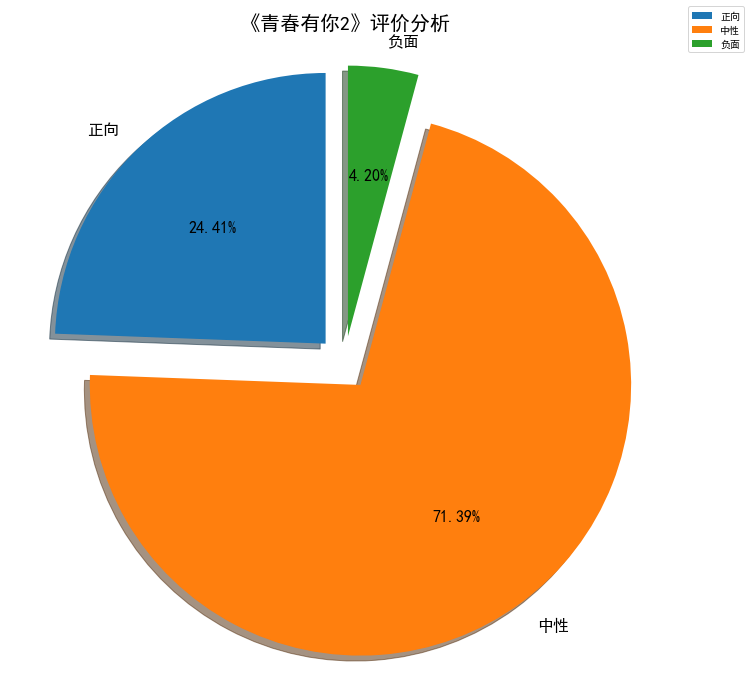

In [99]:
draw_pie()

In [100]:
print(positive[:10])
print(neutral[:10])
print(negative[:10])

['喻言挺可', '宋昕冉太美啦', '雪儿加油呀！你真的越来越好了！要相信自己，我们最喜欢看你在舞台上自信舞蹈的样子了！不要太在意网络上的一些流言蜚语。我会一直支持你，在你的身后支持着你，在我们心中你是最棒的！雪猪猪冲鸭！爱你哟', '我太喜欢了王清和刘雨昕了\n又来刷一遍  在你们为数不多的小分队合体综艺上', '我喜欢孔雪儿', '我爱你，谢可寅', '我看了好几遍，很好看', '好看', '刘雨昕真好看', '嘿嘿嘿']
['又来刷一遍  在你们为数不多的小分队合体综艺上  发光吧  九个人一起', '，LISA学舞只花了2小时，好牛', '一直期待师兄的舞台 今天看完之后我整个人快泪奔了 毕竟是回忆杀，青你2师兄合作舞台，', '.', '蔡徐坤', '好想好想刘老师呀！', '陆珂然，我们大家都会支持你的，我们以后都会陪你走，你永远是一只自由的鸟，送你出道，也不会给你加上镣铐，一定要加油，我们大家一定会陪你走下去的', '陆珂然加油我们会陪你走下去的', '881', '125']
['其实他们每个人都不容易，每天没日没夜的练习，还面临着淘汰心里肯定很难受，大家也就不要再去黑她们了，做训练生的生活真的很苦，可能家里也有不支持的，大家在这样去网络上去评价去定义一个人，就算她们嘴上说我不在乎其实心里压力还是很大的，每个人都有每个人的性格，就不要再去管别人的生活了，不管最后哪几个追梦女孩出道了，我们都要和平点不要去互撕，毕竟青春追梦多远都可以到达！加油吧！女孩们！', '好感人，我都哭了', '喻言雨昕我来啦！我的两个pick呜呜呜王炸组合，他们真的都很好，大家不要恶意比较啊，一起喜欢有实力颜值好性格好的小姐姐们吧', '看个电视太难了', '蔡徐坤，真的值得拥有很多人喜欢，看到训练生姐姐们夸蔡徐坤，都哭了', '我想说我真的不是故意的', '刘雨昕！冲！你真的很值得！我们相信你！勇敢是唯一的回应 你的努力一定不会被辜负的！', '上官喜爱很有实力，很友善。每次都尽力的帮助队友我很喜欢他她，我们不定义每一女生，上官喜爱，你现在就是最美的样子！', '，kiki不要哭，', '讨厌徐鑫文，演可盈，真丑恶心']
